In [1]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM
from keras.layers import GlobalMaxPooling1D
from keras.models import Model
from keras.layers.embeddings import Embedding
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.layers import Input
from keras.layers.merge import Concatenate

import pandas as pd
import numpy as np
import re

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [3]:
comments = pd.read_csv("train.csv")



In [5]:
filter = comments["comment_text"] != ""
comments = comments[filter]
comments = comments.dropna()

In [6]:
toxic_comments_labels = comments[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]]
toxic_comments_labels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


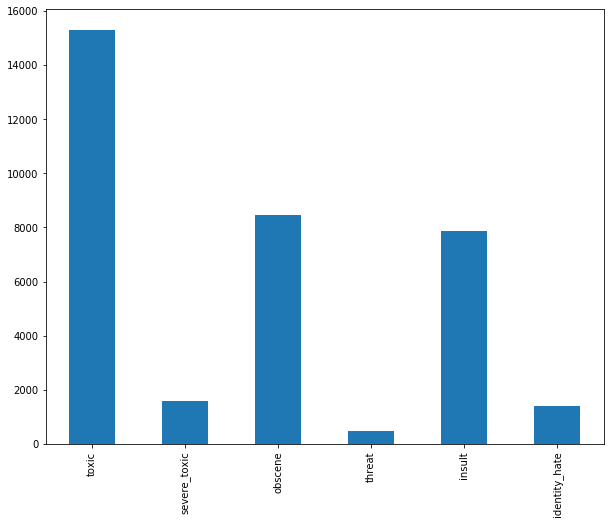

In [7]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 10
fig_size[1] = 8
plt.rcParams["figure.figsize"] = fig_size

toxic_comments_labels.sum(axis=0).plot.bar()

In [8]:
def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence

In [9]:
X = []
sentences = list(comments["comment_text"])
for sen in sentences:
    X.append(preprocess_text(sen))

y = toxic_comments_labels.values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 200

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [12]:
from numpy import array
from numpy import asarray
from numpy import zeros

embeddings_dictionary = dict()

glove_file = open('/home/mohsin/Programs/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary[word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [13]:
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)(deep_inputs)
LSTM_Layer_1 = LSTM(128)(embedding_layer)
dense_layer_1 = Dense(6, activation='sigmoid')(LSTM_Layer_1)
model = Model(inputs=deep_inputs, outputs=dense_layer_1)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [14]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 200)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 200, 100)          14824300  
_________________________________________________________________
lstm_1 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 774       
Total params: 14,942,322
Trainable params: 118,022
Non-trainable params: 14,824,300
_________________________________________________________________
None


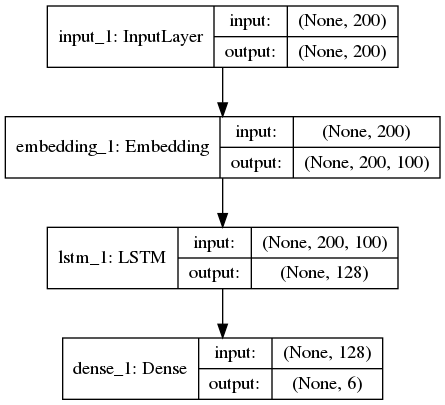

In [15]:
from keras.utils import plot_model
plot_model(model, to_file='model_plot4a.png', show_shapes=True, show_layer_names=True)

In [16]:
history = model.fit(X_train, y_train, batch_size=128, epochs=5, verbose=1, validation_split=0.2)

Train on 102124 samples, validate on 25532 samples
Epoch 1/5
102124/102124 [==============================] - 729s 7ms/step - loss: 0.1349 - acc: 0.9650 - val_loss: 0.0761 - val_acc: 0.9750
Epoch 2/5
102124/102124 [==============================] - 693s 7ms/step - loss: 0.0654 - acc: 0.9781 - val_loss: 0.0598 - val_acc: 0.9794
Epoch 3/5
102124/102124 [==============================] - 689s 7ms/step - loss: 0.0577 - acc: 0.9801 - val_loss: 0.0567 - val_acc: 0.9803
Epoch 4/5
102124/102124 [==============================] - 687s 7ms/step - loss: 0.0546 - acc: 0.9809 - val_loss: 0.0563 - val_acc: 0.9805
Epoch 5/5
102124/102124 [==============================] - 688s 7ms/step - loss: 0.0525 - acc: 0.9815 - val_loss: 0.0545 - val_acc: 0.9806


In [17]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

31915/31915 [==============================] - 117s 4ms/step
Test Score: 0.05341142275766502
Test Accuracy: 0.9811218976974487


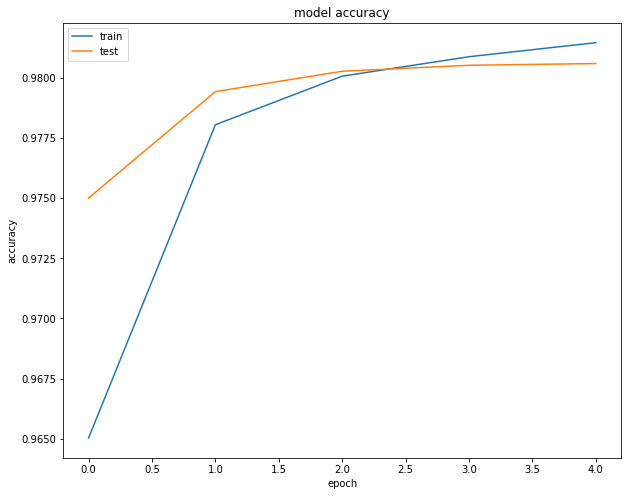

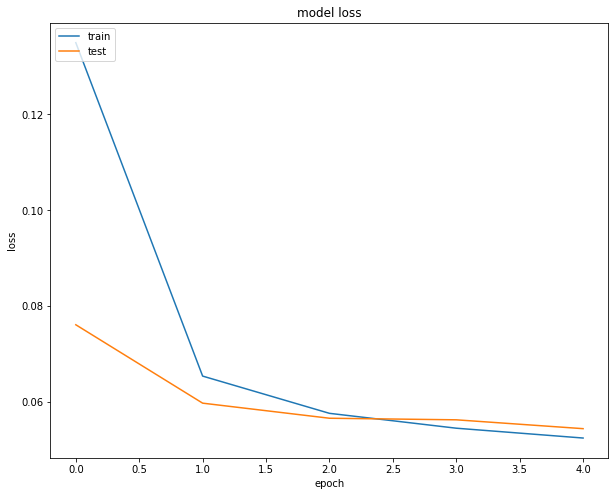

In [18]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [19]:
test_predictions = model.predict(X_test)

print(test_predictions)


[[3.7341052e-01 2.3428798e-03 5.8130175e-02 5.8947802e-03 1.1485684e-01
  1.7497271e-02]
 [2.3266077e-03 8.8437009e-06 4.6116114e-04 4.2226358e-05 5.5164099e-04
  1.1912838e-04]
 [1.9031107e-02 8.0385129e-05 2.9647052e-03 2.8759241e-04 4.4909418e-03
  8.9767575e-04]
 ...
 [1.2517512e-02 5.4251788e-05 2.8325021e-03 1.5848875e-04 2.9866695e-03
  5.0556660e-04]
 [8.6915815e-01 2.2833735e-02 3.7038440e-01 2.5997877e-02 4.9478713e-01
  6.8482995e-02]
 [4.9262345e-03 2.0660977e-05 9.5742941e-04 8.1498292e-05 1.1363849e-03
  2.3599986e-04]]


In [20]:
import pandas as pd 
prediction = model.predict(X_test)
df = pd.DataFrame(prediction, columns = [["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]])

In [21]:
df.shape

(31915, 6)

In [22]:
df.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0.373411,0.002343,0.058130,0.005895,0.114857,0.017497
1,0.002327,0.000009,0.000461,0.000042,0.000552,0.000119
2,0.019031,0.000080,0.002965,0.000288,0.004491,0.000898
3,0.003258,0.000013,0.000706,0.000053,0.000781,0.000155
4,0.008808,0.000037,0.001883,0.000122,0.002101,0.000380
